Comparisons of locomotion predictions of different mechanistic latent variable models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from disp import set_plot


STRAIN_KEY = '_'.join(['NM91', 'ZH23']).lower()
REG_KEY = 'ridge_alpha_10'

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

MASKED = True

# Behavioral predictions from song features

In [2]:
FHEUR = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_mtn_masked.npy'
data = np.load(FHEUR, allow_pickle=True)[0]

SONG_HEURS = [
    'N_S_ONSETS',
    'N_P_ONSETS',
    'N_B_ONSETS',
    'S_TOTAL',
    'P_TOTAL',
    'B_TOTAL',
    # duration/ratio vars are undefined at many timepoints, which significantly changes the dataset used for fitting
    'MN_S_DUR',
    'MN_P_DUR',  
    'MN_B_DUR',
#     'SP_RATIO',
]
# WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480, 1800]
WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480]

LABELS = [
    '# sine\nonsets',
    '# pulse\nonsets',
    '# bout\nonsets',
    
    'Total sine',
    'Total pulse',
    'Total song',
    
    'Mean sine\nduration',
    'Mean pulse\nduration',
    'Mean bout\nduration',
]

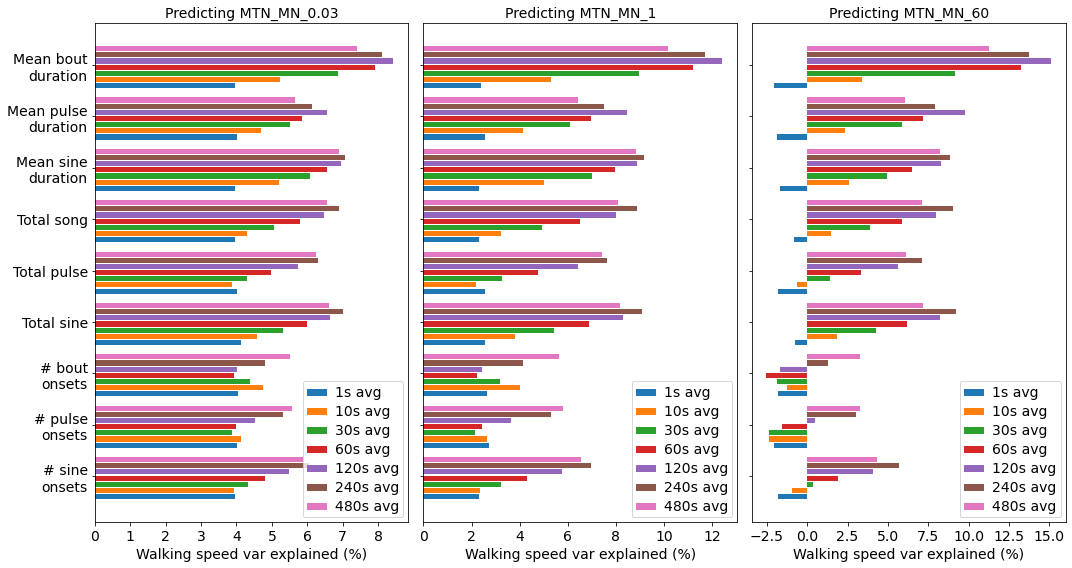

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(1, 3, figsize=(15, 8), tight_layout=True, sharey=True)

r2_heurs_all = {targ: [] for targ in TARGS}

for targ, ax in zip(TARGS, axs):
    r2_test_mn = data['r2_test'][targ].mean(axis=0)
    r2_test_std = data['r2_test'][targ].std(axis=0)
    r2_test_sem = r2_test_std / np.sqrt(data['r2_test'][targ].shape[0])
    
    y_ticks = []
    
    for cfeat, feat in enumerate(SONG_HEURS):
        for cwdw, (wdw, color) in enumerate(zip(WDWS_HEUR, colors)):
            
            icol = data['heurs'].index(f'{feat}_{wdw}')
            ax.barh(cfeat + .12*cwdw, 100*r2_test_mn[icol], height=.1, color=color)
            
            r2_heurs_all[targ].append(data['r2_test'][targ][:, icol])
        
        y_ticks.append(cfeat+ .4)
        
        
    ax.legend([f'{wdw}s avg' for wdw in WDWS_HEUR])
    
    set_plot(ax, y_ticks=y_ticks, y_tick_labels=LABELS, x_label=r'Walking speed var explained (%)', title=f'Predicting {targ}', font_size=14)
    
# fig.savefig('supp/15_fmtn_from_song_feats.svg')

In [4]:
r2_heur_imaxs = {targ: np.argmax(np.array(r2_heurs_all[targ]).mean(axis=1)) for targ in TARGS}
r2_heur_maxs = {targ: np.array(r2_heurs_all[targ]).T[:, r2_heur_imax] for targ, r2_heur_imax in r2_heur_imaxs.items()}

# Basic comparison of single vs population fits using different neural models.

In [5]:
NNRN = 224
NRL_MDLS = [
#     'linma',  # linear neural model w MA-derived filters
    
    'lnr',  # linear-nonlinear model (fit w ridge regr)
    'lnr_relu',  
#     'lnr_relu_flex',
    'lnma_tweaked',  # lin-nonlin neural model w double-exp filter optimized from MA fit
    
    'lnma',  # lin-nonlin neural model w MA-derived filters
    'ma',  # mult-adapt neural model
    
    
#     'linr',  # linear neural model (fit w ridge regr)
    
#     'ma_ind_ta',
    
#     'lin',  # linear neural model
#     'ln',  # linear-nonlinear model
]

LABELS = {
    'ma': 'MA',
    'lnma': 'LN',
    'lnr': 'LN-R',
    'lnr_relu': 'LN-RELU',
#     'lnr_relu_flex': 'LN_FLEX',
    'lnma_tweaked': 'LNMA_TW',
    
    'linma': 'Lin',
    
#     'ma_ind_ta': 'MA_IND_TA',
    
    'MTN': 'Motion',
}

In [6]:
if not MASKED:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

    # single-neuorn fits
    single_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    
else:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

    # single-neuorn fits
    single_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

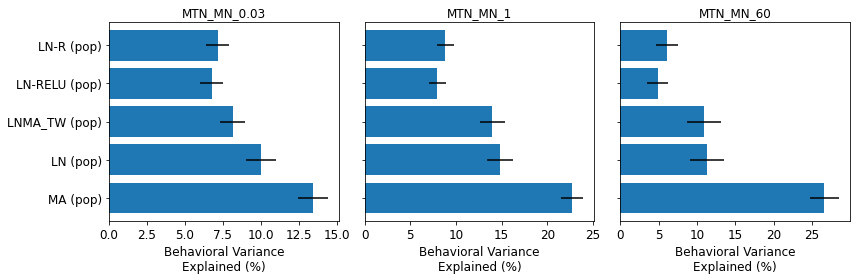

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
                
ma_ppln_r2s = {}

for ax, twdw in zip(axs, TWDWS):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
#     # heuristics
#     labels.append('Timestamp')
#     r2_mns.append(time_rslt['r2_test'][targ].mean())
#     r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
#     labels.append('Bout duration')
#     r2_mns.append(r2_heur_maxs[targ].mean())
#     r2_sems.append(r2_heur_maxs[targ].std() / np.sqrt(len(r2_heur_maxs[targ])))
    
#     # linear fits
#     labels.append('Linear Filter')
#     r2_mns.append(lin_rslt['r2_test'][targ].mean())
#     r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
#     # single neuron results
#     for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
#         r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
#         labels.append(f'{LABELS[nrl_mdl]} (best)')
#         r2_mns.append(r2_maxs.mean())
#         r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
        if nrl_mdl == 'ma':
            ma_ppln_r2s[targ] = ppln_rslt['r2_test'][targ].mean()
        
#     # shuffled MA fit
#     labels.append('MA (shuffled)')
#     r2_mns.append(shfl_rslt['r2_test'][targ].mean())
#     r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems)
    ax.set_xlim(left=0)
    
    ax.set_yticks(np.arange(len(labels)))
    ax.set_ylim(len(r2_mns)-.4, -.6)
    if ax is axs[0]:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
        
    set_plot(ax, x_label='Behavioral Variance\nExplained (%)', title=targ, font_size=12)
    
fig.savefig('supp/16_lnr_sgm_vs_relu.svg')